# Planning

- Selitettävyys on asiakkaalle tärkeätä, joten mennään simppeleillä malleilla. (Tavoite ei ole ennustaa vaan selittää)
- Asiakkaan mukaan vaste ei ole lineaarinen, joten päätöspuut voivat olla parempia kuin lin. regressio.
- Kokeile seuraavia malleja sk-learnista:
  1. Peruspäätöspuu
  1. Random forest
  1. Lineaarinen regressio (vertailukohta, kertoimet helppo tulkita)
- Kohdemuuttuja (y):
  - Joko neljän kohdemuuttujan yhteenlaskettu päiväkohtainen z-score tai
  - Kunkin muuttujan z-score erikseen (neljä eri mallia)
  - Testaile tehtyjen valintojen (mean vs. median, luottamusvälin leveys, ikkunoiden pituus, 10-14 vs. koko päivä), vaikutusta
  - Syötä data ei-aikasarjamuotoisena. Eli niin, että kukin arvo on itsenäinen. Näin dataa voi sekoittaa eikä tarvitse edetä aikajärjestyksessä
    - Tavoite ei ole ennustaa seuraavan askeleen y:tä edellisestä askeleesta.
  
- Selittävät muuttujat (x):
  - Light
  - Rain
  - Temperature
  - Soil water potential
  - Soil water content
  - Absoluuttiset arvot vs. poikkeamat mediaanista
  - Päivä (=vuoden aika) -> muuta päivänumero (1-365) radiaaneiksi, jotta joulukuu ja tammikuu tulevat vierekkäin? 
  - Kokeile näiden lisäksi erilaisia time lageja, sillä intuitiivisesti tuntuisi, että vaste ei välttämättä ole aivan välitön. Esim. kolmen edellisen päivän keskiarvo tms.
    - Älä siis lagaa y:tä, mutta x:iä voi lagata

# Imports

In [343]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression # https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
from sklearn import tree # https://scikit-learn.org/stable/modules/tree.html#regression
from sklearn.ensemble import RandomForestRegressor # https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html

# Read data

In [344]:
df1 = pd.read_csv('./data/GPP_NEE_flux_2001-2022.csv')
df2 = pd.read_csv('./data/voc_2010-2022.csv')
df3 = pd.read_csv('./data/latent_heat_flux_2018-2022.csv')
df4 = pd.read_csv('./data/latent_heat_flux_2001-2018.csv')
df5 = pd.read_csv('./data/sensible_heat_flux_2001-2022.csv')
df6 = pd.read_csv('./data/HYY_META.PAR_1997-01-01--9999-09-09.csv')
df7 = pd.read_csv('./data/HYY_META.Precipacc_2005-04-01--9999-09-09.csv')
df8 = pd.read_csv('./data/HYY_META.T672_1997-01-01--9999-09-09.csv')
df9 = pd.read_csv('./data/HYY_META.wpsoil_A_2005-06-17--9999-09-09.csv')
df10 = pd.read_csv('./data/HYY_META.wsoil_B1_p50_2007-02-01--2023-04-04.csv')

# Drop columnns 'Unnamed: 0'
df1 = df1.drop(columns=['Unnamed: 0'])
df2 = df2.drop(columns=['Unnamed: 0'])
df3 = df3.drop(columns=['Unnamed: 0'])
df4 = df4.drop(columns=['Unnamed: 0'])
df5 = df5.drop(columns=['Unnamed: 0'])
df6 = df6.drop(columns=['Unnamed: 0'])
df7 = df7.drop(columns=['Unnamed: 0'])
df8 = df8.drop(columns=['Unnamed: 0'])
df9 = df9.drop(columns=['Unnamed: 0'])
df10 = df10.drop(columns=['Unnamed: 0'])

# Convert time labels to datetime objects
df1['Datetime'] = pd.to_datetime(df1['Datetime'])
df2['Datetime'] = pd.to_datetime(df2['Datetime'])
df3['Datetime'] = pd.to_datetime(df3['Datetime'])
df4['Datetime'] = pd.to_datetime(df4['Datetime'])
df5['Datetime'] = pd.to_datetime(df5['Datetime'])
df6['Datetime'] = pd.to_datetime(df6['Datetime'])
df7['Datetime'] = pd.to_datetime(df7['Datetime'])
df8['Datetime'] = pd.to_datetime(df8['Datetime'])
df9['Datetime'] = pd.to_datetime(df9['Datetime'])
df10['Datetime'] = pd.to_datetime(df10['Datetime'])

# Config parameters

## Time period

In [345]:
# 1) Select start time of the analysis
START_TIME = pd.to_datetime('2010-06-01')

# 2) Select the months of interest
START_MONTH = 1
END_MONTH = 12

# 3) Select the measurement hours to consider. Allowed values are 'all', 'noon'
DAILY_HOURS = 'noon'
# DAILY_HOURS = 'all'
assert DAILY_HOURS in ['all', 'noon']

## Aggregation

In [346]:
# 1) Select the method for aggregating raw measurements to daily values. Allowed values are 'mean' or 'median'
DAILY_AGG_METHOD = 'median'
# DAILY_AGG_METHOD = 'mean'
assert DAILY_AGG_METHOD in ['mean', 'median']

# 2) Set the window size and aggregation method for combining daily measurements
WINDOW_SIZE = 3
# WINDOW_AGG_METHOD = 'median'
WINDOW_AGG_METHOD = 'mean'
assert WINDOW_AGG_METHOD in ['mean', 'median']

# Prepare the data

In [347]:
if DAILY_HOURS=='noon':   
    # keep only observations occurring during 10.00-14.00 each day
    df1 = df1[(df1['Datetime'].dt.hour>=10) & (df1['Datetime'].dt.hour<=14)]
    df2 = df2[(df2['Datetime'].dt.hour>=10) & (df2['Datetime'].dt.hour<=14)]
    df3 = df3[(df3['Datetime'].dt.hour>=10) & (df3['Datetime'].dt.hour<=14)]
    df4 = df4[(df4['Datetime'].dt.hour>=10) & (df4['Datetime'].dt.hour<=14)]
    df5 = df5[(df5['Datetime'].dt.hour>=10) & (df5['Datetime'].dt.hour<=14)]
    df6 = df6[(df6['Datetime'].dt.hour>=10) & (df6['Datetime'].dt.hour<=14)]
    df7 = df7[(df7['Datetime'].dt.hour>=10) & (df7['Datetime'].dt.hour<=14)]
    df8 = df8[(df8['Datetime'].dt.hour>=10) & (df8['Datetime'].dt.hour<=14)]
    df9 = df9[(df9['Datetime'].dt.hour>=10) & (df9['Datetime'].dt.hour<=14)]
    df10 = df10[(df10['Datetime'].dt.hour>=10) & (df10['Datetime'].dt.hour<=14)]

In [348]:
# Keep only the rows where NEE_gapfilling_method is 0
df1 = df1[df1.NEE_gapfilling_method == 0]

# Reset the index
df1.reset_index(drop=True, inplace=True)

In [349]:
# Aggregate to daily values
if DAILY_AGG_METHOD == 'mean':
    daily_df1 = df1.resample('D', on = 'Datetime').mean().reset_index()
    daily_df2 = df2.resample('D', on = 'Datetime').mean().reset_index()
    daily_df3 = df3.resample('D', on = 'Datetime').mean().reset_index()
    daily_df4 = df4.resample('D', on = 'Datetime').mean().reset_index()
    daily_df5 = df5.resample('D', on = 'Datetime').mean().reset_index()
    daily_df6 = df6.resample('D', on = 'Datetime').mean().reset_index()
    daily_df7 = df7.resample('D', on = 'Datetime').sum().reset_index()
    daily_df8 = df8.resample('D', on = 'Datetime').mean().reset_index()
    daily_df9 = df9.resample('D', on = 'Datetime').mean().reset_index()
    daily_df10 = df10.resample('D', on = 'Datetime').mean().reset_index()
elif DAILY_AGG_METHOD == 'median':
    daily_df1 = df1.resample('D', on = 'Datetime').median().reset_index()
    daily_df2 = df2.resample('D', on = 'Datetime').median().reset_index()
    daily_df3 = df3.resample('D', on = 'Datetime').median().reset_index()
    daily_df4 = df4.resample('D', on = 'Datetime').median().reset_index()
    daily_df5 = df5.resample('D', on = 'Datetime').median().reset_index()
    daily_df6 = df6.resample('D', on = 'Datetime').median().reset_index()
    daily_df7 = df7.resample('D', on = 'Datetime').sum().reset_index()
    daily_df8 = df8.resample('D', on = 'Datetime').median().reset_index()
    daily_df9 = df9.resample('D', on = 'Datetime').median().reset_index()
    daily_df10 = df10.resample('D', on = 'Datetime').median().reset_index()
else:
    raise ValueError('agg_method must be either "mean" or "median"')

In [350]:
# Combine latent heat flux data from 2001-2018 and 2018-2022 to same dataframe: lh_df
daily_df4 = daily_df4.rename(columns={'HYY_EDDY233.LE': 'lh_flux'})
daily_df4 = daily_df4.drop(columns=['HYY_EDDY233.Qc_LE'])

daily_df3 = daily_df3.rename(columns={'latent_heat_flux_after_4-2018': 'lh_flux'})
daily_df3 = daily_df3.drop(columns=['latent_heat_flux_quality_flag_after_4-2018'])
lh_df = pd.concat([daily_df4, daily_df3], ignore_index=True)

In [351]:
# Drop unnecessary columns
daily_df1 = daily_df1.drop(columns=['NEE_gapfilling_method', 'GPP'])
daily_df5 = daily_df5.drop(columns=['sensible_heat_flux_gapfilling_method'])
daily_df2 = daily_df2.drop(columns=['methanol_flux', 'acetone_flux', 'acetaldehyde_flux'])

In [352]:
# Merge all variables into one dataframe
ddf = pd.merge(daily_df1, daily_df2, on='Datetime', how='outer')
ddf = pd.merge(ddf, lh_df, on='Datetime', how='outer')
ddf = pd.merge(ddf, daily_df5, on='Datetime', how='outer')
ddf = pd.merge(ddf, daily_df6, on='Datetime', how='outer')
ddf = pd.merge(ddf, daily_df7, on='Datetime', how='outer')
ddf = pd.merge(ddf, daily_df8, on='Datetime', how='outer')
ddf = pd.merge(ddf, daily_df9, on='Datetime', how='outer')
ddf = pd.merge(ddf, daily_df10, on='Datetime', how='outer')

In [353]:
# Keep only the measurements after start_time
ddf = ddf[ddf['Datetime'] >= START_TIME]

# Filter data between start_month and end_month
ddf = ddf[(ddf['Datetime'].dt.month >= START_MONTH) & (ddf['Datetime'].dt.month <= END_MONTH)]#.copy()

In [354]:
# Convert each daily value into a rolling value over the selected window size 
if WINDOW_AGG_METHOD == 'median':
    ddf['monoterp_rm'] = ddf['monoterpene_flux'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['sensible_heat_rm'] = ddf['sensible_heat_flux'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
    ddf['latent_heat_rm'] = ddf['lh_flux'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
    ddf['nee_rm'] = ddf['NEE'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
    ddf['PAR_rm'] = ddf['HYY_META.PAR'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
    ddf['precip_rm'] = ddf['HYY_META.Precipacc'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
    ddf['t672_rm'] = ddf['HYY_META.T672'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
    ddf['wpsoil_A_rm'] = ddf['HYY_META.wpsoil_A'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
    ddf['wsoil_B1_p50_rm'] = ddf['HYY_META.wsoil_B1_p50'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).median()
elif WINDOW_AGG_METHOD == 'mean':
    ddf['monoterp_rm'] = ddf['monoterpene_flux'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['sensible_heat_rm'] = ddf['sensible_heat_flux'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['latent_heat_rm'] = ddf['lh_flux'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['nee_rm'] = ddf['NEE'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['PAR_rm'] = ddf['HYY_META.PAR'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['precip_rm'] = ddf['HYY_META.Precipacc'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['t672_rm'] = ddf['HYY_META.T672'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['wpsoil_A_rm'] = ddf['HYY_META.wpsoil_A'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()
    ddf['wsoil_B1_p50_rm'] = ddf['HYY_META.wsoil_B1_p50'].rolling(window=WINDOW_SIZE, min_periods=1, center=True).mean()

In [355]:
# Add a column for the day of year
ddf['day'] = ddf['Datetime'].dt.dayofyear

# Add a column for the year
ddf['year'] = ddf['Datetime'].dt.year

In [356]:
ddf.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4962 entries, 4899 to 9860
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Datetime               4962 non-null   datetime64[ns]
 1   NEE                    4012 non-null   float64       
 2   monoterpene_flux       2226 non-null   float64       
 3   lh_flux                4154 non-null   float64       
 4   sensible_heat_flux     4597 non-null   float64       
 5   HYY_META.PAR           4926 non-null   float64       
 6   HYY_META.Precipacc     4962 non-null   float64       
 7   HYY_META.T672          4776 non-null   float64       
 8   HYY_META.wpsoil_A      4864 non-null   float64       
 9   HYY_META.wsoil_B1_p50  4687 non-null   float64       
 10  monoterp_rm            2571 non-null   float64       
 11  sensible_heat_rm       4598 non-null   float64       
 12  latent_heat_rm         4329 non-null   float64       
 13  nee_r

In [357]:
ddf.drop(columns=[
    'NEE',
    'monoterpene_flux',
    'lh_flux',
    'sensible_heat_flux',
    'HYY_META.PAR',
    'HYY_META.Precipacc',
    'HYY_META.T672',
    'HYY_META.wpsoil_A',
    'HYY_META.wsoil_B1_p50',
    ], inplace=True)

# Calculate quantiles

In [358]:
# Pivot the DataFrame so that rows are days and columns are years
df_mono = ddf.pivot(index='day', columns='year', values='monoterp_rm')
df_sensible = ddf.pivot(index='day', columns='year', values='sensible_heat_rm')
df_latent = ddf.pivot(index='day', columns='year', values='latent_heat_rm')
df_nee = ddf.pivot(index='day', columns='year', values='nee_rm')
df_PAR = ddf.pivot(index='day', columns='year', values='PAR_rm')
df_precip = ddf.pivot(index='day', columns='year', values='precip_rm')
df_t672 = ddf.pivot(index='day', columns='year', values='t672_rm')
df_wpsoil_A = ddf.pivot(index='day', columns='year', values='wpsoil_A_rm')
df_wsoil_B1_p50 = ddf.pivot(index='day', columns='year', values='wsoil_B1_p50_rm')

# Drop column year from ddf
ddf.drop(columns=['year'], inplace=True)

In [359]:
# Create daily 0.1 and 0.9 quantiles for each variable
mono_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_mono.index) + 1))
sensible_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_sensible.index) + 1))
latent_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_latent.index) + 1))
nee_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_nee.index) + 1))
PAR_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_PAR.index) + 1))
precip_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_precip.index) + 1))
t672_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_t672.index) + 1))
wpsoil_A_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_wpsoil_A.index) + 1))
wsoil_B1_p50_quant = pd.DataFrame(index=[0.1, 0.9], columns=range(1, len(df_wsoil_B1_p50.index) + 1))

In [360]:
# Instead of looking only at one day, search the quantiles from a period of +- one week around the day in question

def create_arrays(row_index, dataframe):
    current_row = dataframe.iloc[row_index].to_numpy()
    
    start_index = max(1, row_index - 7)
    end_index = min(row_index + 6, len(dataframe)-1)
    
    previous_rows = dataframe.iloc[start_index:row_index].to_numpy()
    next_rows = dataframe.iloc[row_index + 1:end_index + 1].to_numpy()
    
    # Concatenate arrays
    result_array = np.concatenate([previous_rows.flatten(), current_row, next_rows.flatten()])
    
    return result_array

for index, row in df_mono.iterrows():
    if index == len(df_mono):
        break
    array = create_arrays(index, df_mono)
    lquant = np.nanquantile(array, 0.1)
    mono_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    mono_quant.at[0.9, index] = uquant

for index, row in df_sensible.iterrows():
    if index == len(df_sensible):
        break
    array = create_arrays(index, df_sensible)
    lquant = np.nanquantile(array, 0.1)
    sensible_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    sensible_quant.at[0.9, index] = uquant

for index, row in df_latent.iterrows():
    if index == len(df_latent):
        break
    array = create_arrays(index, df_latent)
    lquant = np.nanquantile(array, 0.1)
    latent_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    latent_quant.at[0.9, index] = uquant

for index, row in df_nee.iterrows():
    if index == len(df_nee):
        break
    array = create_arrays(index, df_nee)
    lquant = np.nanquantile(array, 0.1)
    nee_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    nee_quant.at[0.9, index] = uquant

for index, row in df_PAR.iterrows():
    if index == len(df_PAR):
        break
    array = create_arrays(index, df_PAR)
    lquant = np.nanquantile(array, 0.1)
    PAR_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    PAR_quant.at[0.9, index] = uquant

for index, row in df_precip.iterrows():
    if index == len(df_precip):
        break
    array = create_arrays(index, df_precip)
    lquant = np.nanquantile(array, 0.1)
    precip_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    precip_quant.at[0.9, index] = uquant

for index, row in df_t672.iterrows():
    if index == len(df_t672):
        break
    array = create_arrays(index, df_t672)
    lquant = np.nanquantile(array, 0.1)
    t672_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    t672_quant.at[0.9, index] = uquant

for index, row in df_wpsoil_A.iterrows():
    if index == len(df_wpsoil_A):
        break
    array = create_arrays(index, df_wpsoil_A)
    lquant = np.nanquantile(array, 0.1)
    wpsoil_A_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    wpsoil_A_quant.at[0.9, index] = uquant

for index, row in df_wsoil_B1_p50.iterrows():
    if index == len(df_wsoil_B1_p50):
        break
    array = create_arrays(index, df_wsoil_B1_p50)
    lquant = np.nanquantile(array, 0.1)
    wsoil_B1_p50_quant.at[0.1, index] = lquant
    uquant = np.nanquantile(array, 0.9)
    wsoil_B1_p50_quant.at[0.9, index] = uquant

# Calculate z-scores

In [361]:
# Create a new dataframe for z-scores as a copy of ddf
z_scores = ddf.copy()
z_scores.set_index('Datetime', inplace=True)

# calculate z-scores for each variable
for index, row in z_scores.iterrows():
    day = index.dayofyear
    z_scores.at[index, 'monoterp_zscore']=(row['monoterp_rm']-df_mono.loc[day].mean())/df_mono.loc[day].std(ddof=0)
    z_scores.at[index, 'sensible_heat_zscore']=(row['sensible_heat_rm']-df_sensible.loc[day].mean())/df_sensible.loc[day].std(ddof=0)
    z_scores.at[index, 'latent_heat_zscore']=(row['latent_heat_rm']-df_latent.loc[day].mean())/df_latent.loc[day].std(ddof=0)
    z_scores.at[index, 'nee_zscore']=(row['nee_rm']-df_nee.loc[day].mean())/df_nee.loc[day].std(ddof=0)
    z_scores.at[index, 'PAR_zscore']=(row['PAR_rm']-df_PAR.loc[day].mean())/df_PAR.loc[day].std(ddof=0)
    z_scores.at[index, 'precip_zscore']=(row['precip_rm']-df_precip.loc[day].mean())/df_precip.loc[day].std(ddof=0)
    z_scores.at[index, 't672_zscore']=(row['t672_rm']-df_t672.loc[day].mean())/df_t672.loc[day].std(ddof=0)
    z_scores.at[index, 'wpsoil_A_zscore']=(row['wpsoil_A_rm']-df_wpsoil_A.loc[day].mean())/df_wpsoil_A.loc[day].std(ddof=0)
    z_scores.at[index, 'wsoil_B1_p50_zscore']=(row['wsoil_B1_p50_rm']-df_wsoil_B1_p50.loc[day].mean())/df_wsoil_B1_p50.loc[day].std(ddof=0)
    

z_scores.drop(columns=[
    'monoterp_rm',
    'sensible_heat_rm',
    'latent_heat_rm',
    'nee_rm',
    'PAR_rm',
    'precip_rm',
    't672_rm',
    'wpsoil_A_rm',
    'wsoil_B1_p50_rm'], inplace=True)

z_scores_2010 = z_scores[z_scores.index.year == 2010]
z_scores_2011 = z_scores[z_scores.index.year == 2011]
z_scores_2012 = z_scores[z_scores.index.year == 2012]
z_scores_2013 = z_scores[z_scores.index.year == 2013]
z_scores_2014 = z_scores[z_scores.index.year == 2014]
z_scores_2015 = z_scores[z_scores.index.year == 2015]
z_scores_2016 = z_scores[z_scores.index.year == 2016]
z_scores_2017 = z_scores[z_scores.index.year == 2017]
z_scores_2018 = z_scores[z_scores.index.year == 2018]
z_scores_2019 = z_scores[z_scores.index.year == 2019]
z_scores_2020 = z_scores[z_scores.index.year == 2020]
z_scores_2021 = z_scores[z_scores.index.year == 2021]
z_scores_2022 = z_scores[z_scores.index.year == 2022]

z_scores_2010.set_index('day', inplace=True)
z_scores_2011.set_index('day', inplace=True)
z_scores_2012.set_index('day', inplace=True)
z_scores_2013.set_index('day', inplace=True)
z_scores_2014.set_index('day', inplace=True)
z_scores_2015.set_index('day', inplace=True)
z_scores_2016.set_index('day', inplace=True)
z_scores_2017.set_index('day', inplace=True)
z_scores_2018.set_index('day', inplace=True)
z_scores_2019.set_index('day', inplace=True)
z_scores_2020.set_index('day', inplace=True)
z_scores_2021.set_index('day', inplace=True)
z_scores_2022.set_index('day', inplace=True)

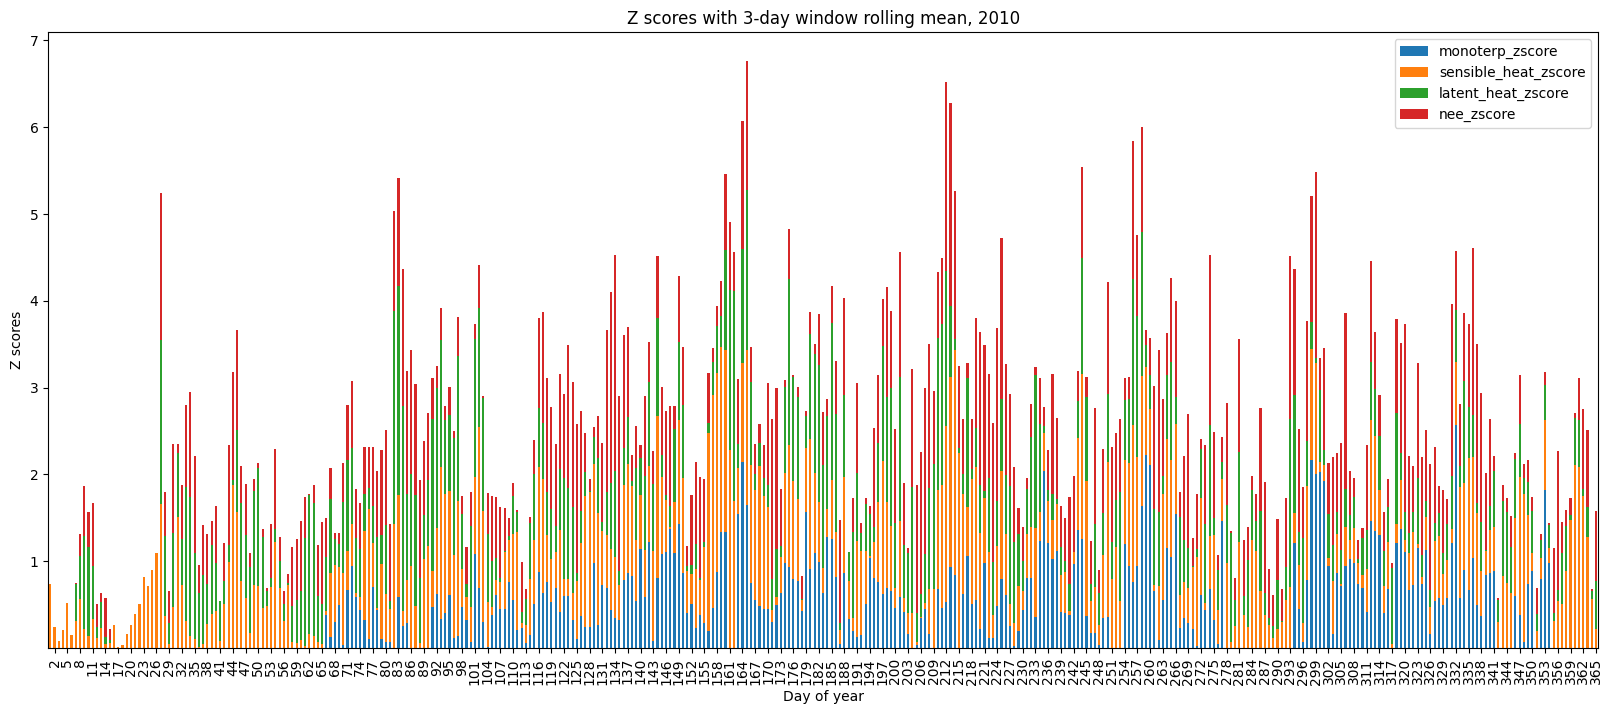

In [362]:
# Plot year 2011 as an example
z_scores_2011.iloc[:,:4].abs().plot(kind='bar', stacked=True, figsize=(20, 8))

ticks = list(range(1, len(z_scores_2011.index)+1, 3))

plt.xticks(ticks, labels=np.array(z_scores_2011.index + 1)[np.array(ticks)-1])
plt.title(f'Z scores with {WINDOW_SIZE}-day window rolling {WINDOW_AGG_METHOD}, 2010')
plt.xlabel('Day of year')
plt.ylabel('Z scores')

plt.show()

# Feature engineering

In [363]:
# For clarity, make z_scores and ddf have the same columns in same order
z_scores.reset_index(inplace=True)
day = ddf.pop('day')
ddf.insert(1, 'day', day)

# Merge the dataframes
df=ddf.merge(z_scores, on='Datetime', how='inner')

# Drop column 'Datetime' and 'day_y'
df.drop(columns=['Datetime', 'day_y'], inplace=True)

# Rename column 'day_x' to 'day'
df.rename(columns={'day_x': 'day'}, inplace=True)

In [368]:
# Convert day number to circular coordinates
def day_to_coordinates(day_number):
    normalized_day = day_number / 365.0
    angle = normalized_day * 2 * math.pi
    x = np.cos(angle)
    y = np.sin(angle)
    return x, y

# Apply the function 
df[['x_coord', 'y_coord']] = df['day'].apply(lambda x: pd.Series(day_to_coordinates(x)))

# Move the x and y columns to the front of the DataFrame
df = df[['x_coord', 'y_coord'] + [col for col in df.columns if col not in ['x_coord', 'y_coord']]]

# Drop the day column 
df.drop(columns=['day'], inplace=True)

In [371]:
# Create lagging variables. Lag is the average of previous x steps
lag_size = 3

# Define the columns to apply lag
lag_columns = ['PAR_rm', 'precip_rm', 't672_rm', 'wpsoil_A_rm', 'wsoil_B1_p50_rm']

# Define the lag size
lag_size = 3

# Calculate lagging variables for specified columns
lag_df = df[lag_columns].rolling(window=lag_size).mean().shift(1)

# Rename the columns with lag suffix
lag_df.columns = [col + '_lag' + str(lag_size) for col in lag_df.columns]

# Concatenate the original DataFrame with lagging variables
df = pd.concat([df, lag_df], axis=1)

In [377]:
# Impute missing values with the mean of the column
df.fillna(df.mean(), inplace=True)

In [378]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 25 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   x_coord               4962 non-null   float64
 1   y_coord               4962 non-null   float64
 2   monoterp_rm           4962 non-null   float64
 3   sensible_heat_rm      4962 non-null   float64
 4   latent_heat_rm        4962 non-null   float64
 5   nee_rm                4962 non-null   float64
 6   PAR_rm                4962 non-null   float64
 7   precip_rm             4962 non-null   float64
 8   t672_rm               4962 non-null   float64
 9   wpsoil_A_rm           4962 non-null   float64
 10  wsoil_B1_p50_rm       4962 non-null   float64
 11  monoterp_zscore       4962 non-null   float64
 12  sensible_heat_zscore  4962 non-null   float64
 13  latent_heat_zscore    4962 non-null   float64
 14  nee_zscore            4962 non-null   float64
 15  PAR_zscore           

# ML Setup 1
- Sum of z-scores as y
- Absolute rolling values as x's

In [379]:
df1=df.copy()

# Add new column z_score as sum of monoterp_zscore, sensible_heat_zscore, latent_heat_zscore, nee_zscore
df1['z_score'] = df1['monoterp_zscore'] + df1['sensible_heat_zscore'] + df1['latent_heat_zscore'] + df1['nee_zscore']

# Select columns to use in this setup
df1 = df1[['x_coord', 'y_coord', 'z_score', 'PAR_rm', 'precip_rm', 't672_rm', 'wpsoil_A_rm', 'wsoil_B1_p50_rm', 'PAR_rm_lag3', 'precip_rm_lag3', 't672_rm_lag3', 'wpsoil_A_rm_lag3', 'wsoil_B1_p50_rm_lag3']]

df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4962 entries, 0 to 4961
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   x_coord               4962 non-null   float64
 1   y_coord               4962 non-null   float64
 2   z_score               4962 non-null   float64
 3   PAR_rm                4962 non-null   float64
 4   precip_rm             4962 non-null   float64
 5   t672_rm               4962 non-null   float64
 6   wpsoil_A_rm           4962 non-null   float64
 7   wsoil_B1_p50_rm       4962 non-null   float64
 8   PAR_rm_lag3           4962 non-null   float64
 9   precip_rm_lag3        4962 non-null   float64
 10  t672_rm_lag3          4962 non-null   float64
 11  wpsoil_A_rm_lag3      4962 non-null   float64
 12  wsoil_B1_p50_rm_lag3  4962 non-null   float64
dtypes: float64(13)
memory usage: 504.1 KB


In [380]:
# Shuffle the DataFrame
df1 = df1.sample(frac=1).reset_index(drop=True)

# Split the DataFrame into features (X) and target variable (y)
X = df1.drop(columns=['z_score'])
y = df1['z_score']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shapes of the resulting sets
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (3969, 12)
X_test shape: (993, 12)
y_train shape: (3969,)
y_test shape: (993,)


## Random forest

In [403]:
# Fit the model
rf=RandomForestRegressor().fit(X_train, y_train)

# R2 score for train set
print("Train R2:", rf.score(X_train, y_train))

# R2 score for test set
print("Test R2:", rf.score(X_test, y_test))

Train R2: 0.9404574482933603
Test R2: 0.609366606053118


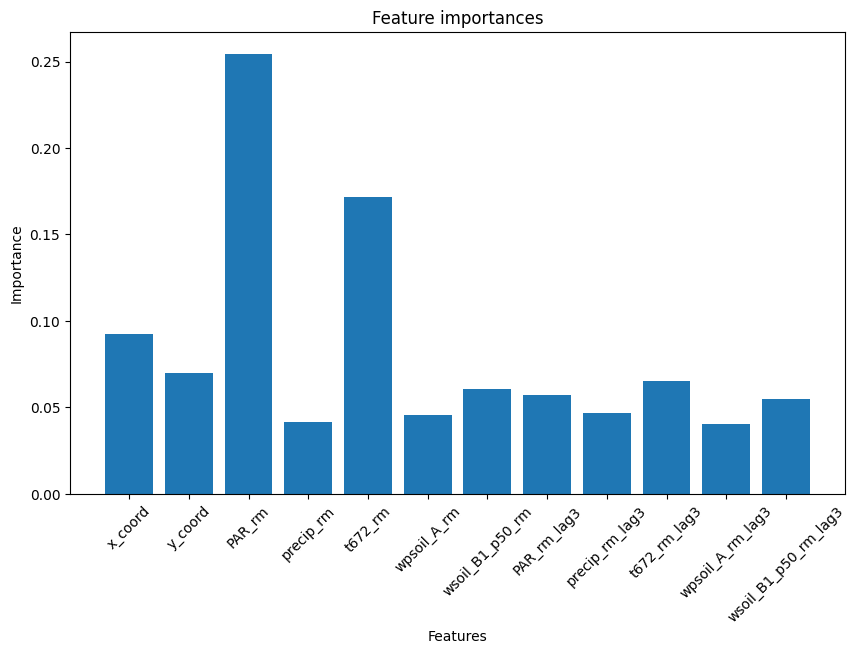

In [404]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, rf.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importances')
plt.xticks(rotation=45)
plt.show()

## Decision tree

In [405]:
# Fit the model
dt = tree.DecisionTreeRegressor().fit(X_train, y_train)

# R2 score for train set
print("Train R2:", dt.score(X_train, y_train))

# R2 score for test set
print("Test R2:", dt.score(X_test, y_test))

Train R2: 1.0
Test R2: 0.15502002168064466


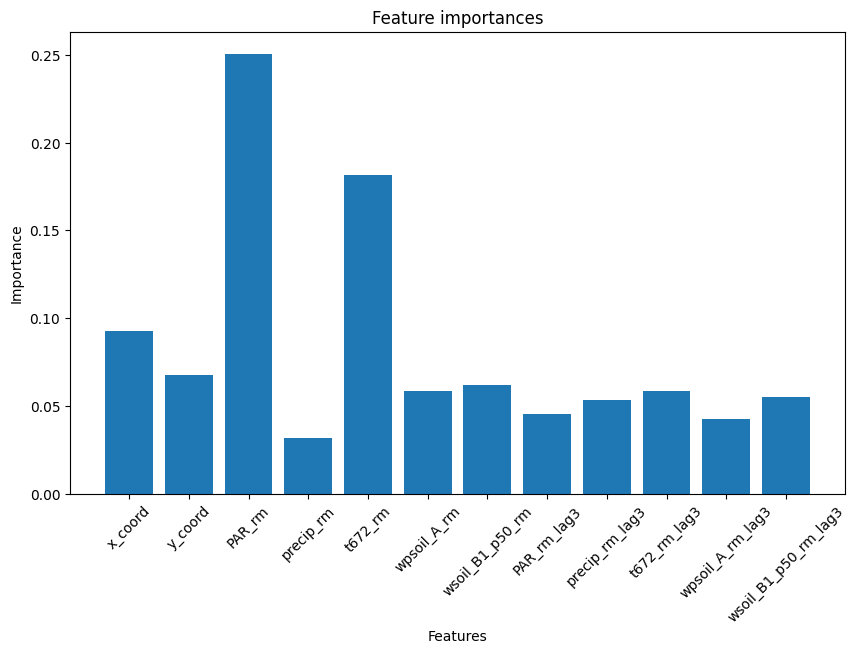

In [407]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, dt.feature_importances_)
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature importances')
plt.xticks(rotation=45)
plt.show()

## Linear regression

In [408]:
# Fit the model
lr=LinearRegression().fit(X_train, y_train)

# R2 score for train set
print("Train R2:", lr.score(X_train, y_train))

# R2 score for test set
print("Test R2:", lr.score(X_test, y_test))

Train R2: 0.31371903171256965
Test R2: 0.2886340922417472


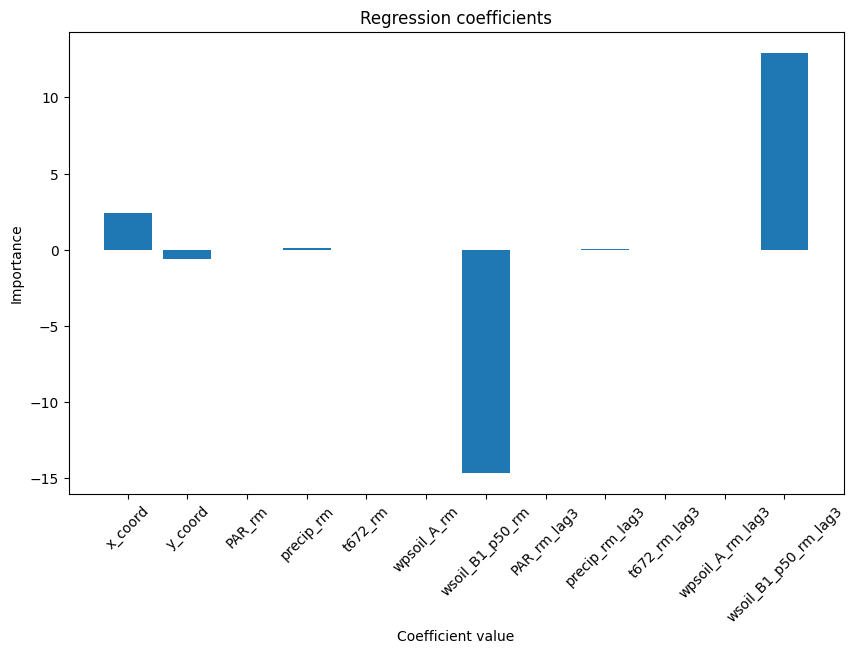

In [412]:
# Plot regression coefficients
plt.figure(figsize=(10, 6))
plt.bar(X_train.columns, lr.coef_)
plt.xlabel('Coefficient value')
plt.ylabel('Importance')
plt.title('Regression coefficients')
plt.xticks(rotation=45)
plt.show()